In [1]:
from numpy import zeros, dot, conj, prod, sqrt, exp, pi, diag, angle, array, argwhere, real, floor, frombuffer, uint8, where, stack, asarray, expand_dims
from numpy.linalg import qr, multi_dot, svd
from numpy.random import uniform, normal, randint
import matplotlib.pyplot as plt
import pandas as pd
import io
import cv2
import pickle
import time

In [2]:
max_iter = 10000
SNR_dB = 10
SNR_lin = 10**(SNR_dB/10)
bit_codebook = 2
num_ant = 2
num_classes = 2**bit_codebook

In [3]:
def codebook_gen(num_ant, bit_codebook):
        """
        Generate DFT codebbok of matrix preocders
        :return: matrix of matrix preocders
        """
        num_precoders = 2**bit_codebook
        codebook = zeros(num_precoders, dtype=object)

        for p in range(0, num_precoders):
            precoder = zeros((num_ant, num_ant), dtype=complex)
            for m in range(0, num_ant):
                for n in range(0, num_ant):
                    w = exp(1j*2*pi*(n/num_ant)*(m + p/num_precoders))
                    precoder[n, m] = (1/sqrt(num_ant))*w

            codebook[p] = precoder

        return codebook


In [4]:
# file_name = 'img_data_' + str(max_iter) + '_' + str(SNR_dB) + 'dB.pckl'
crop_dimensions = 256
file_name = 'img_data_' + str(max_iter) + '_' + str(SNR_dB) + 'dB_' + str(crop_dimensions) + 'x' + str(crop_dimensions) + '.pckl'
with open(file_name, 'rb') as f:
    precoder_img_data, precoder_labels = pickle.load(f)

In [5]:
codebook = codebook_gen(num_ant, bit_codebook)

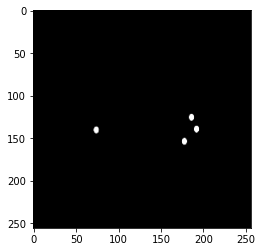

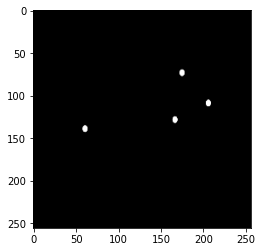

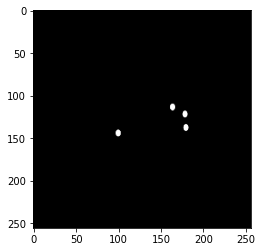

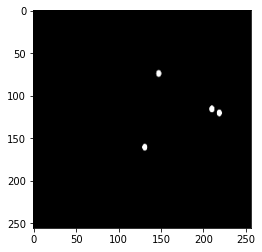

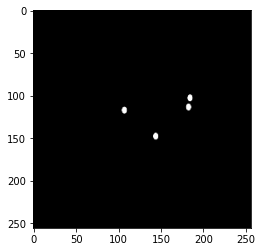

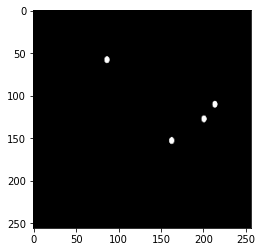

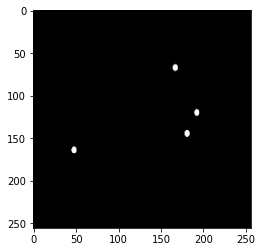

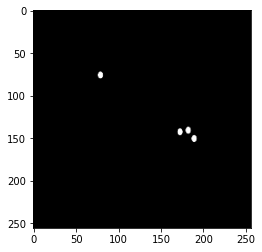

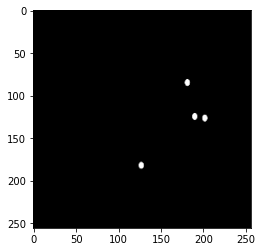

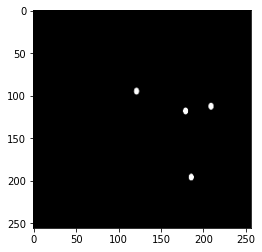

In [6]:

num_images = 10
for i in range(num_images):
    plt.imshow(precoder_img_data[i, 0, :, :], cmap = plt.cm.gray)
    plt.show()

In [7]:
import torch 
from torch.utils.data import Dataset, DataLoader, random_split

In [8]:
class PrecoderDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.data)

precoder_dataset = PrecoderDataset(precoder_img_data, precoder_labels)
train, val = random_split(precoder_dataset, [int(0.8*max_iter), int(0.2*max_iter)])
train_loader = DataLoader(
    train,
    batch_size=128,
    shuffle=True,
    num_workers=0,
)
# increase batch size
val_loader = DataLoader(
    val,
    batch_size=128,
    shuffle=True,
    num_workers=0,
)

In [9]:
# for batch_idx, (data, target) in enumerate(train_loader):
#     print('Train: Batch idx {}, data shape {}, target shape {}'.format(
#         batch_idx, data.shape, target.shape))
    
# for batch_idx, (data, target) in enumerate(val_loader):
#     print('Val: Batch idx {}, data shape {}, target shape {}'.format(
#         batch_idx, data.shape, target.shape))

In [10]:
from torch import nn 
from torch import optim 
from torchsummary import summary

In [11]:
# model = nn.Sequential(
#         nn.Linear(70*70, 2000),
#         nn.ReLU(),
#         nn.Linear(2000, 64),
#         nn.ReLU(),
#         nn.Linear(64, num_classes),
#         nn.Softmax(),
# )


class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(64*64*64, 4096)
        self.linear_2 = torch.nn.Linear(4096, 256)
        self.linear_3 = torch.nn.Linear(256, num_classes)
        self.dropout = torch.nn.Dropout(p=0.3)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_3(x)
        pred = self.softmax(x)

        return pred

model = Model()

if torch.cuda.is_available():
    model.cuda()


optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
loss = nn.CrossEntropyLoss()

In [12]:
num_epochs = 500 # Number of times you go through the whole dataset
for epoch in range(num_epochs):
    
    # TRAINING
    model.train()
    training_total_correct = 0
    training_losses = list()
    for batch in train_loader:
        
        x, y = batch # extracted from the batch 
        
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

        # step 1: forward pass 
        prob = model(x) 
        
        output = prob
        target = y
        
        # step 2: compute objective function - measuring distance between the output of the network vs actual answer 
        obj_func = loss(output, target)
        
        # step 3: clear the gradients 
        model.zero_grad()
        
        # step 4: accumulate partial derivatives of obj_func wrt parameters 
        obj_func.backward()
        
        # step 5: step in the opposite direction of the gradient 
        optimizer.step()

        training_losses.append(obj_func.item())
        
        max_prob, max_ind = torch.max(output, 1)
#         print(len(max_ind))
        for ind in range(len(max_ind)):
#             print(max_ind[ind], y[ind])
            if torch.equal(max_ind[ind], y[ind]):
                training_total_correct += 1
#     print(training_total_correct)  
#     print(f'Epoch {epoch + 1}, training loss: {torch.tensor(training_losses).mean():.8f}')
    
    
    # VALIDATION
    model.eval()

    validation_total_correct = 0
    validation_losses = list()
    for batch in val_loader:
        
        x, y = batch # extracted from the batch 
        
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

        # step 1: forward pass 
        with torch.no_grad():
            prob = model(x) 
        
        output = prob
        target = y
        
        # step 2: compute objective function - measuring distance between the output of the network vs actual answer 
        obj_func = loss(output, target)
        validation_losses.append(obj_func.item())
        
        max_prob, max_ind = torch.max(output, 1)
        
        for ind in range(len(max_ind)):
#             print(max_ind[ind], y[ind])
            if torch.equal(max_ind[ind], y[ind]):
                validation_total_correct += 1
#     print(len(train), len(val))          
    training_accuracy = (training_total_correct/len(train))*100  
    validation_accuracy = (validation_total_correct/len(val))*100   
    
    print(f'Epoch {epoch + 1}, training loss: {torch.tensor(training_losses).mean():.8f}, training accuracy: {training_accuracy}%, validation loss: {torch.tensor(validation_losses).mean():.8f}, validation accuracy: {validation_accuracy}%')

/home/utsa/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


RuntimeError: CUDA out of memory. Tried to allocate 4.00 GiB (GPU 0; 10.91 GiB total capacity; 8.29 GiB already allocated; 1.72 GiB free; 8.30 GiB reserved in total by PyTorch)